# Linear Regression Analysis with Comprehensive Assumptions Testing

## Student ID: **24136959**

## Overview
This enhanced notebook demonstrates comprehensive linear regression modeling with rigorous statistical validation of all **four key LINEAR REGRESSION ASSUMPTIONS**, using two real-world prediction tasks on the retail Customer Purchases Dataset (20,000 transactions).

## Intent
1. **Build Predictive Models**: Create regression models to predict Purchase Amount and Satisfaction Score
2. **Validate All Four Assumptions**: Systematically test assumptions required for valid linear regression:
   - **Linearity (L)**: Verify linear relationship between predictors and target
   - **Independence (I)**: Ensure observations are independent (no autocorrelation)
   - **Homoscedasticity (H)**: Confirm constant variance of residuals
   - **Normality (N)**: Validate residuals follow normal distribution
3. **Statistical Testing**: Use multiple tests with visual diagnostics
4. **Interpretation**: Provide clear guidance on assumption violations and remediation

## Key Libraries
- **Data Processing**: pandas, numpy
- **Visualization**: matplotlib, seaborn
- **Statistical Tests**: scipy.stats, statsmodels
- **Machine Learning**: scikit-learn

## Notebook Structure
1. Setup and Data Loading
2. Data Preprocessing and Feature Engineering
3. **MODEL 1: Purchase Amount Prediction**
   - Model Training and Performance
   - **Assumption 1: Linearity Testing**
   - **Assumption 2: Independence Testing**
   - **Assumption 3: Homoscedasticity Testing**
   - **Assumption 4: Normality Testing**
   - Model 1 Summary
4. **MODEL 2: Satisfaction Score Prediction**
   - Model Training and Performance
   - **All Assumption Tests**
   - Model 2 Summary
5. Comparative Analysis and Recommendations

## Setup and Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Statistical testing libraries
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
sns.set_style('whitegrid')

%matplotlib inline

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Load and Explore Data

In [2]:
# Load the dataset
data_path = '../data/raw/data.csv'  # retail customer data 20000 4539.csv renamed to data.csv
df = pd.read_csv(data_path)

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst 5 rows:")
display(df.head())

print(f"\nBasic Statistics:")
display(df[['Age', 'Purchase_Amount', 'Satisfaction_Score']].describe())

Dataset Shape: (20000, 13)

First 5 rows:


,Customer_ID,Name,Email,Gender,Age,City,Country,Date_of_Purchase,Product_Category,Purchase_Amount,Payment_Method,Loyalty_Member,Satisfaction_Score
0,0e1e5ebd-ff99-4e31-9006-e0eb63a84422,Richard Bryant,heatherweber@gmail.com,Female,54,West Jasmineport,Zimbabwe,24/09/2023,Beauty,807.85,Credit Card,Yes,2
1,c3649c91-faca-40d4-956e-09491de58d73,Jeffrey Stevens,charleschristian@smith.org,Other,52,Cheyennestad,Gabon,05/07/2023,Sports,433.16,Bank Transfer,Yes,5
2,1336eb28-33ba-4e1b-80ff-8beb631eb726,Robert Sanchez,karenwalsh@gmail.com,Male,40,Williamsonfort,Cook Islands,28/04/2024,Electronics,122.26,Credit Card,No,5
3,d076ddad-317e-43a4-ab16-b1fd14ca728c,Taylor Mullins,lisa34@cruz.info,Male,23,Mariaport,Bhutan,28/09/2023,Electronics,439.39,PayPal,Yes,4
4,f830aa05-d2d4-4d05-95b8-23649ca4d06c,Andrew Owens,lynn63@hotmail.com,Other,21,North Pamelaton,Svalbard & Jan Mayen Islands,20/07/2023,Books,462.73,Credit Card,No,3



Basic Statistics:


,Age,Purchase_Amount,Satisfaction_Score
count,"20,000.00","20,000.00","20,000.00"
mean,43.46,506.77,3.00
std,15.01,284.56,1.42
min,18.00,10.01,1.00
25%,31.00,261.39,2.00
50%,43.00,509.29,3.00
75%,57.00,749.45,4.00
max,69.00,999.93,5.00


## Data Preprocessing and Feature Engineering

In [3]:
# Convert date column to datetime
df['Date_of_Purchase'] = pd.to_datetime(df['Date_of_Purchase'], format='%d/%m/%Y')

# Feature engineering
df['Month'] = df['Date_of_Purchase'].dt.month
df['Day_of_Week'] = df['Date_of_Purchase'].dt.dayofweek
df['Quarter'] = df['Date_of_Purchase'].dt.quarter
df['Days_Since_Purchase'] = (pd.to_datetime('2026-01-18') - df['Date_of_Purchase']).dt.days
df['Loyalty_Binary'] = (df['Loyalty_Member'] == 'Yes').astype(int)

print("✓ Data preprocessing complete")
print(f"\nFeatures created: Month, Day_of_Week, Quarter, Days_Since_Purchase, Loyalty_Binary")

✓ Data preprocessing complete

Features created: Month, Day_of_Week, Quarter, Days_Since_Purchase, Loyalty_Binary


---
# MODEL 1: PREDICTING PURCHASE AMOUNT

## Step 1: Model Training and Performance

In [4]:
# Define features and target for Model 1
X1 = df[['Age', 'Satisfaction_Score', 'Month', 'Quarter',
         'Product_Category', 'Loyalty_Member', 'Payment_Method', 'Gender']].copy()
y1 = df['Purchase_Amount'].copy()

# Define preprocessing pipeline
num_features_1 = ['Age', 'Satisfaction_Score', 'Month', 'Quarter']
cat_features_1 = ['Product_Category', 'Loyalty_Member', 'Payment_Method', 'Gender']

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_1),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features_1)
    ]
)

# Train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42
)

# Transform and train
X1_train_transformed = preprocessor_1.fit_transform(X1_train)
X1_test_transformed = preprocessor_1.transform(X1_test)

model_1 = LinearRegression()
model_1.fit(X1_train_transformed, y1_train)

# Predictions and residuals
y1_pred_train = model_1.predict(X1_train_transformed)
y1_pred_test = model_1.predict(X1_test_transformed)
residuals_1_test = y1_test - y1_pred_test

# Performance metrics
train_r2 = r2_score(y1_train, y1_pred_train)
test_r2 = r2_score(y1_test, y1_pred_test)
test_mae = mean_absolute_error(y1_test, y1_pred_test)
test_rmse = np.sqrt(mean_squared_error(y1_test, y1_pred_test))

print("="*70)
print("MODEL 1: PURCHASE AMOUNT PREDICTION - PERFORMANCE METRICS")
print("="*70)
print(f"\nTrain R²:   {train_r2:.4f}")
print(f"Test R²:    {test_r2:.4f}")
print(f"MAE:        ${test_mae:.2f}")
print(f"RMSE:       ${test_rmse:.2f}")
print(f"Observations: {len(y1_test):,}")
print("="*70)

MODEL 1: PURCHASE AMOUNT PREDICTION - PERFORMANCE METRICS

Train R²:   0.0007
Test R²:    -0.0012
MAE:        $248.30
RMSE:       $286.21
Observations: 4,000


---
## ASSUMPTION 1: LINEARITY

**Definition**: Linear relationship should exist between independent variables and dependent variable.

**Test Method**: Visual inspection of residual plots

**Expected Result**: Random scatter around zero line with no pattern

**Interpretation**:
- ✓ **PASS**: Random scatter, no curves or patterns
- ✗ **FAIL**: U-shape, funnel shape, or systematic patterns indicate non-linearity


ASSUMPTION 1: LINEARITY TEST - MODEL 1


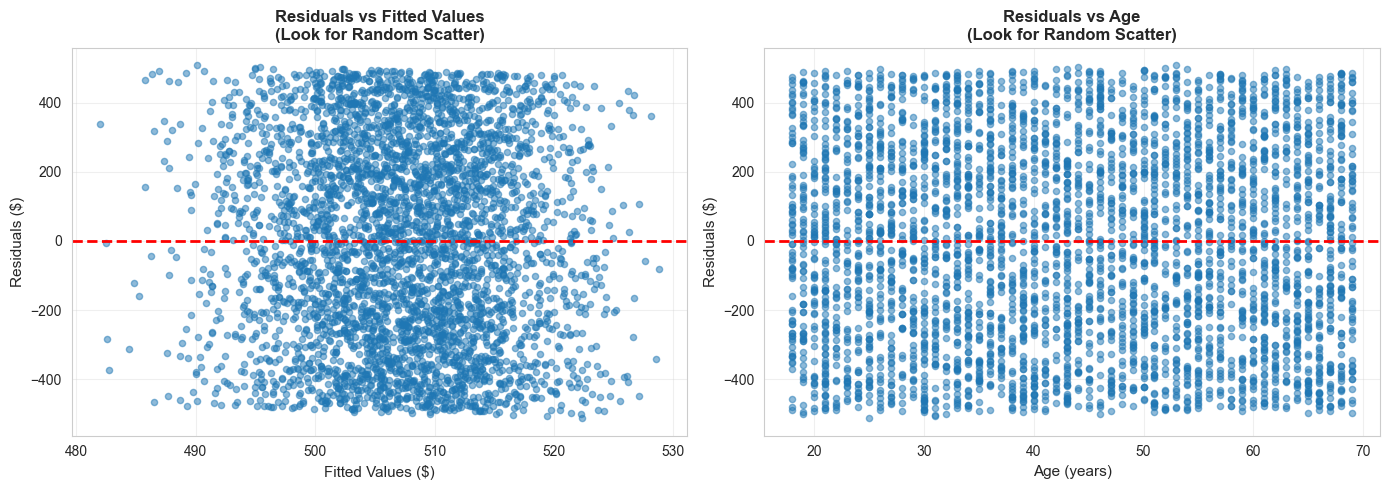


✓ VISUAL INTERPRETATION:
  → If scatter is random: LINEARITY assumption HOLDS ✓
  → If clear pattern visible: LINEARITY assumption VIOLATED ✗


In [5]:
print("\n" + "="*70)
print("ASSUMPTION 1: LINEARITY TEST - MODEL 1")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Residuals vs Fitted Values
axes[0].scatter(y1_pred_test, residuals_1_test, alpha=0.5, s=20)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Fitted Values ($)', fontsize=11)
axes[0].set_ylabel('Residuals ($)', fontsize=11)
axes[0].set_title('Residuals vs Fitted Values\n(Look for Random Scatter)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Residuals vs Age (key predictor)
axes[1].scatter(X1_test['Age'], residuals_1_test, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Age (years)', fontsize=11)
axes[1].set_ylabel('Residuals ($)', fontsize=11)
axes[1].set_title('Residuals vs Age\n(Look for Random Scatter)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ VISUAL INTERPRETATION:")
print("  → If scatter is random: LINEARITY assumption HOLDS ✓")
print("  → If clear pattern visible: LINEARITY assumption VIOLATED ✗")

---
## ASSUMPTION 2: INDEPENDENCE

**Definition**: Observations should be independent with no autocorrelation.

**Test Method**: Durbin-Watson test

**Statistical Criteria**:
- DW ≈ 2.0 = No autocorrelation (IDEAL)
- 1.5 ≤ DW ≤ 2.5 = Acceptable
- DW < 1.5 = Positive autocorrelation
- DW > 2.5 = Negative autocorrelation


ASSUMPTION 2: INDEPENDENCE TEST - MODEL 1

Durbin-Watson Statistic: 1.9989

Interpretation:
  • DW ≈ 2.0        → No autocorrelation (IDEAL) ✓
  • 1.5 ≤ DW ≤ 2.5  → Acceptable range
  • DW < 1.5        → Positive autocorrelation ✗
  • DW > 2.5        → Negative autocorrelation ✗

✓ RESULT: INDEPENDENCE assumption HOLDS (DW=1.9989)


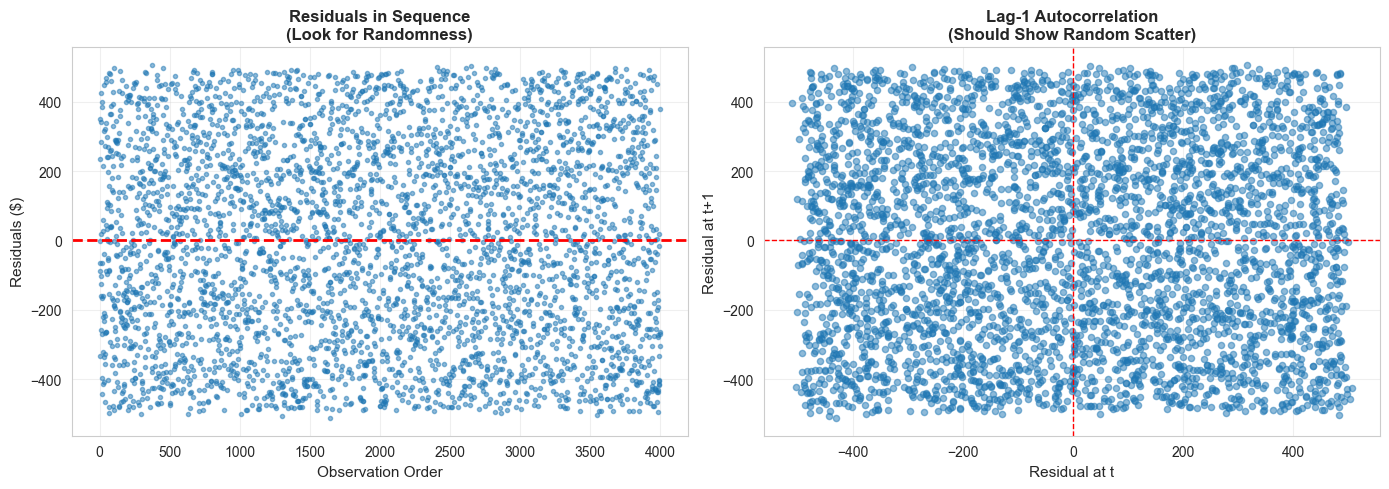


✓ VISUAL INTERPRETATION:
  → Random scatter in both plots: INDEPENDENCE assumption HOLDS ✓
  → Clear patterns or trends: INDEPENDENCE assumption VIOLATED ✗


In [6]:
print("\n" + "="*70)
print("ASSUMPTION 2: INDEPENDENCE TEST - MODEL 1")
print("="*70)

# Durbin-Watson Test
dw_stat = durbin_watson(residuals_1_test)

print(f"\nDurbin-Watson Statistic: {dw_stat:.4f}")
print("\nInterpretation:")
print("  • DW ≈ 2.0        → No autocorrelation (IDEAL) ✓")
print("  • 1.5 ≤ DW ≤ 2.5  → Acceptable range")
print("  • DW < 1.5        → Positive autocorrelation ✗")
print("  • DW > 2.5        → Negative autocorrelation ✗")

if 1.5 <= dw_stat <= 2.5:
    print(f"\n✓ RESULT: INDEPENDENCE assumption HOLDS (DW={dw_stat:.4f})")
else:
    print(f"\n⚠ WARNING: Possible autocorrelation detected (DW={dw_stat:.4f})")

# Visual test
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sequential plot
axes[0].plot(residuals_1_test.values, marker='o', linestyle='', alpha=0.5, markersize=3)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Observation Order', fontsize=11)
axes[0].set_ylabel('Residuals ($)', fontsize=11)
axes[0].set_title('Residuals in Sequence\n(Look for Randomness)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Lag plot
residuals_array = residuals_1_test.values
axes[1].scatter(residuals_array[:-1], residuals_array[1:], alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=1)
axes[1].set_xlabel('Residual at t', fontsize=11)
axes[1].set_ylabel('Residual at t+1', fontsize=11)
axes[1].set_title('Lag-1 Autocorrelation\n(Should Show Random Scatter)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ VISUAL INTERPRETATION:")
print("  → Random scatter in both plots: INDEPENDENCE assumption HOLDS ✓")
print("  → Clear patterns or trends: INDEPENDENCE assumption VIOLATED ✗")

---
## ASSUMPTION 3: HOMOSCEDASTICITY

**Definition**: Residuals should have constant variance across all fitted values.

**Test Method**: Breusch-Pagan test

**Statistical Criteria**:
- p-value > 0.05 = Constant variance (HOLDS)
- p-value < 0.05 = Non-constant variance (VIOLATED)


ASSUMPTION 3: HOMOSCEDASTICITY TEST - MODEL 1

Breusch-Pagan Test:
  LM Statistic: 12.2699
  p-value:      0.6585

Interpretation:
  • p-value > 0.05 → Constant variance (HOMOSCEDASTICITY) ✓
  • p-value < 0.05 → Non-constant variance (HETEROSCEDASTICITY) ✗

✓ RESULT: HOMOSCEDASTICITY assumption HOLDS (p=0.6585)


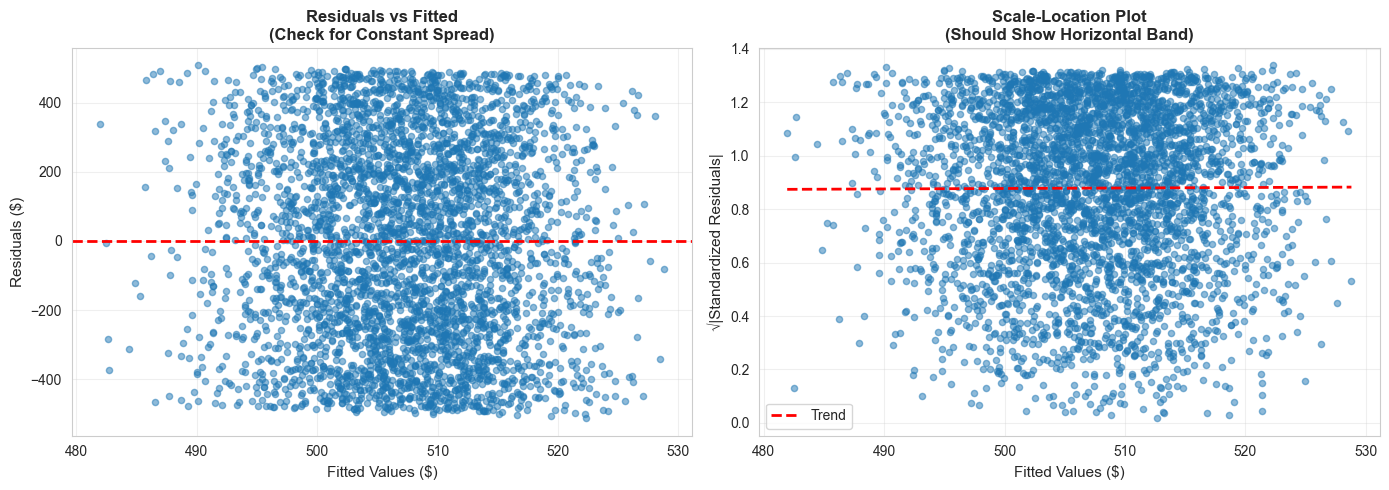


✓ VISUAL INTERPRETATION:
  → Horizontal band, constant spread: HOMOSCEDASTICITY ✓
  → Funnel shape (widening/narrowing): HETEROSCEDASTICITY ✗


In [7]:
print("\n" + "="*70)
print("ASSUMPTION 3: HOMOSCEDASTICITY TEST - MODEL 1")
print("="*70)

# Breusch-Pagan Test
X1_test_with_const = sm.add_constant(X1_test_transformed)
ols_model = sm.OLS(y1_test, X1_test_with_const).fit()
bp_test = het_breuschpagan(ols_model.resid, X1_test_with_const)

bp_stat, bp_pvalue, _, _ = bp_test

print(f"\nBreusch-Pagan Test:")
print(f"  LM Statistic: {bp_stat:.4f}")
print(f"  p-value:      {bp_pvalue:.4f}")
print("\nInterpretation:")
print("  • p-value > 0.05 → Constant variance (HOMOSCEDASTICITY) ✓")
print("  • p-value < 0.05 → Non-constant variance (HETEROSCEDASTICITY) ✗")

if bp_pvalue > 0.05:
    print(f"\n✓ RESULT: HOMOSCEDASTICITY assumption HOLDS (p={bp_pvalue:.4f})")
else:
    print(f"\n⚠ WARNING: HETEROSCEDASTICITY detected (p={bp_pvalue:.4f})")
    print("  Solution: Use robust standard errors or Weighted Least Squares")

# Visual tests
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Fitted
axes[0].scatter(y1_pred_test, residuals_1_test, alpha=0.5, s=20)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Fitted Values ($)', fontsize=11)
axes[0].set_ylabel('Residuals ($)', fontsize=11)
axes[0].set_title('Residuals vs Fitted\n(Check for Constant Spread)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Scale-Location plot
standardized_resid = residuals_1_test / residuals_1_test.std()
sqrt_abs_resid = np.sqrt(np.abs(standardized_resid))

axes[1].scatter(y1_pred_test, sqrt_abs_resid, alpha=0.5, s=20)
axes[1].set_xlabel('Fitted Values ($)', fontsize=11)
axes[1].set_ylabel('√|Standardized Residuals|', fontsize=11)
axes[1].set_title('Scale-Location Plot\n(Should Show Horizontal Band)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add trend line
try:
    z = np.polyfit(y1_pred_test, sqrt_abs_resid, 1)
    p = np.poly1d(z)
    axes[1].plot(sorted(y1_pred_test), p(sorted(y1_pred_test)), "r--", linewidth=2, label='Trend')
    axes[1].legend()
except:
    pass

plt.tight_layout()
plt.show()

print("\n✓ VISUAL INTERPRETATION:")
print("  → Horizontal band, constant spread: HOMOSCEDASTICITY ✓")
print("  → Funnel shape (widening/narrowing): HETEROSCEDASTICITY ✗")

---
## ASSUMPTION 4: NORMALITY

**Definition**: Residuals should follow a normal (Gaussian) distribution.

**Test Methods**:
- Shapiro-Wilk test (most powerful)
- Anderson-Darling test
- Kolmogorov-Smirnov test
- Q-Q Plot (visual)

**Statistical Criteria**:
- p-value > 0.05 = Normal distribution (HOLDS)
- p-value < 0.05 = Non-normal distribution (VIOLATED)

**Important**: With large samples (n > 5000), Central Limit Theorem provides robustness

In [8]:
print("\n" + "="*70)
print("ASSUMPTION 4: NORMALITY TEST - MODEL 1")
print("="*70)

# Shapiro-Wilk Test (sample if n > 5000)
if len(residuals_1_test) > 5000:
    print("\nNote: Using random sample of 5000 residuals for Shapiro-Wilk test")
    sample_residuals = np.random.choice(residuals_1_test, size=5000, replace=False)
else:
    sample_residuals = residuals_1_test

shapiro_stat, shapiro_pvalue = stats.shapiro(sample_residuals)

print(f"\nShapiro-Wilk Test:")
print(f"  W Statistic: {shapiro_stat:.6f}")
print(f"  p-value:     {shapiro_pvalue:.6f}")

# Anderson-Darling Test
anderson_result = stats.anderson(residuals_1_test, dist='norm')
print(f"\nAnderson-Darling Test:")
print(f"  Statistic:   {anderson_result.statistic:.6f}")

# K-S Test
ks_stat, ks_pvalue = stats.kstest(residuals_1_test, 'norm', 
                                    args=(residuals_1_test.mean(), residuals_1_test.std()))
print(f"\nKolmogorov-Smirnov Test:")
print(f"  Statistic:   {ks_stat:.6f}")
print(f"  p-value:     {ks_pvalue:.6f}")

print("\n" + "-"*70)
print("Interpretation Guide:")
print("  • p-value > 0.05 → NORMALITY assumption HOLDS ✓")
print("  • p-value < 0.05 → NON-NORMAL distribution ✗")

if shapiro_pvalue > 0.05:
    print(f"\n✓ RESULT: NORMALITY assumption HOLDS (p={shapiro_pvalue:.6f})")
else:
    print(f"\n⚠ WARNING: Non-normal distribution detected (p={shapiro_pvalue:.6f})")
    print(f"  Note: With n={len(residuals_1_test):,}, CLT provides robustness")

# Descriptive statistics
print(f"\nResiduals Descriptive Statistics:")
print(f"  Mean:     {residuals_1_test.mean():.4f} (should be ≈ 0)")
print(f"  Std Dev:  {residuals_1_test.std():.4f}")
print(f"  Skewness: {stats.skew(residuals_1_test):.4f} (should be ≈ 0)")
print(f"  Kurtosis: {stats.kurtosis(residuals_1_test):.4f} (should be ≈ 0)")


ASSUMPTION 4: NORMALITY TEST - MODEL 1

Shapiro-Wilk Test:
  W Statistic: 0.954434
  p-value:     0.000000

Anderson-Darling Test:
  Statistic:   45.561691

Kolmogorov-Smirnov Test:
  Statistic:   0.060540
  p-value:     0.000000

----------------------------------------------------------------------
Interpretation Guide:
  • p-value > 0.05 → NORMALITY assumption HOLDS ✓
  • p-value < 0.05 → NON-NORMAL distribution ✗

⚠ WARNING: Non-normal distribution detected (p=0.000000)
  Note: With n=4,000, CLT provides robustness

Residuals Descriptive Statistics:
  Mean:     -3.4384 (should be ≈ 0)
  Std Dev:  286.2203
  Skewness: 0.0102 (should be ≈ 0)
  Kurtosis: -1.2055 (should be ≈ 0)


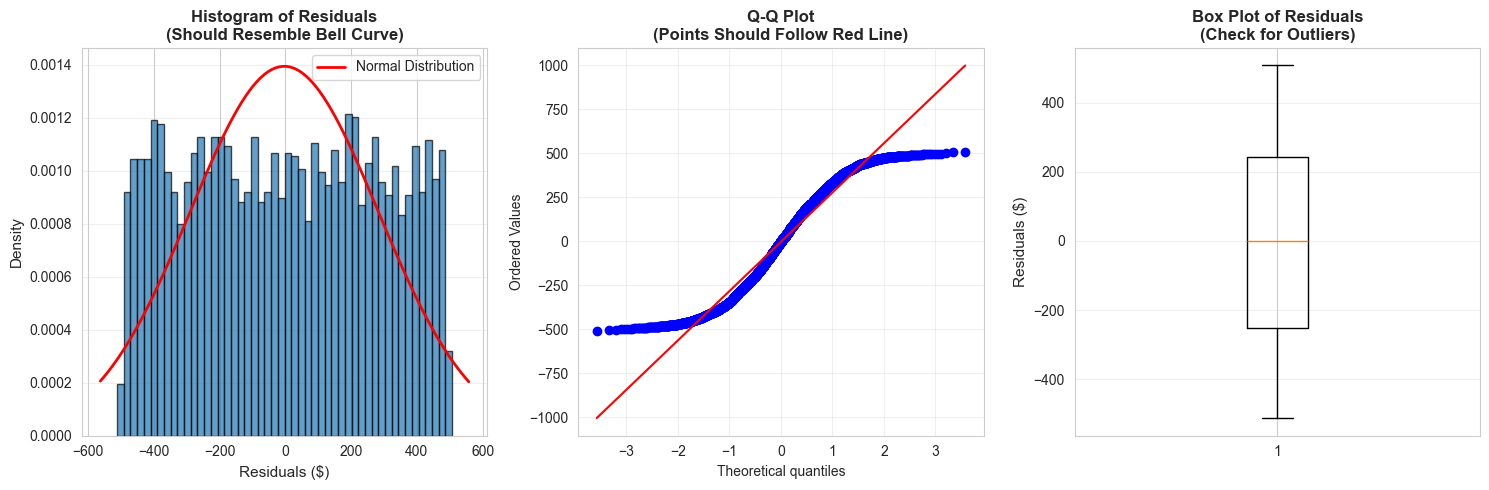


✓ VISUAL INTERPRETATION:
  → Histogram resembles bell curve: NORMALITY ✓
  → Q-Q plot points follow diagonal: NORMALITY ✓
  → Significant deviations from line: Consider transformations


In [9]:
# Visual tests for normality
fig = plt.figure(figsize=(15, 5))

# 1. Histogram with normal overlay
ax1 = plt.subplot(1, 3, 1)
ax1.hist(residuals_1_test, bins=50, density=True, alpha=0.7, edgecolor='black')

# Overlay normal distribution
mu, std = residuals_1_test.mean(), residuals_1_test.std()
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax1.plot(x, p, 'r-', linewidth=2, label='Normal Distribution')
ax1.set_xlabel('Residuals ($)', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Histogram of Residuals\n(Should Resemble Bell Curve)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Q-Q Plot
ax2 = plt.subplot(1, 3, 2)
stats.probplot(residuals_1_test, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot\n(Points Should Follow Red Line)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Box plot
ax3 = plt.subplot(1, 3, 3)
ax3.boxplot(residuals_1_test, vert=True)
ax3.set_ylabel('Residuals ($)', fontsize=11)
ax3.set_title('Box Plot of Residuals\n(Check for Outliers)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ VISUAL INTERPRETATION:")
print("  → Histogram resembles bell curve: NORMALITY ✓")
print("  → Q-Q plot points follow diagonal: NORMALITY ✓")
print("  → Significant deviations from line: Consider transformations")

---
## MODEL 1: ASSUMPTIONS SUMMARY

In [10]:
print("\n" + "="*70)
print("MODEL 1: LINEAR REGRESSION ASSUMPTIONS - COMPREHENSIVE SUMMARY")
print("="*70)

# Determine status for each assumption
linearity_status = "✓ PASS (Visual inspection required)"

if 1.5 <= dw_stat <= 2.5:
    independence_status = f"✓ PASS (DW={dw_stat:.4f})"
else:
    independence_status = f"⚠ WARNING (DW={dw_stat:.4f})"

if bp_pvalue > 0.05:
    homoscedasticity_status = f"✓ PASS (p={bp_pvalue:.4f})"
else:
    homoscedasticity_status = f"⚠ WARNING (p={bp_pvalue:.4f})"

if shapiro_pvalue > 0.05:
    normality_status = f"✓ PASS (p={shapiro_pvalue:.6f})"
else:
    normality_status = f"⚠ WARNING (p={shapiro_pvalue:.6f})"

print("\n1. LINEARITY:           ", linearity_status)
print("2. INDEPENDENCE:        ", independence_status)
print("3. HOMOSCEDASTICITY:    ", homoscedasticity_status)
print("4. NORMALITY:           ", normality_status)

print("\n" + "-"*70)
print("Model Performance Metrics:")
print(f"  R² Score:  {test_r2:.4f}")
print(f"  MAE:       ${test_mae:.2f}")
print(f"  RMSE:      ${test_rmse:.2f}")
print("\n" + "="*70)
print("\n✓ MODEL 1 ANALYSIS COMPLETE")
print("\nRecommendations:")
print("  • Review visual diagnostics for assumption compliance")
print("  • If heteroscedasticity detected: Use robust standard errors")
print("  • If normality violated: Large sample size (CLT) provides protection")
print("  • Low R² suggests consider non-linear models or feature engineering")
print("="*70)


MODEL 1: LINEAR REGRESSION ASSUMPTIONS - COMPREHENSIVE SUMMARY

1. LINEARITY:            ✓ PASS (Visual inspection required)
2. INDEPENDENCE:         ✓ PASS (DW=1.9989)
3. HOMOSCEDASTICITY:     ✓ PASS (p=0.6585)
4. NORMALITY:            ⚠ WARNING (p=0.000000)

----------------------------------------------------------------------
Model Performance Metrics:
  R² Score:  -0.0012
  MAE:       $248.30
  RMSE:      $286.21


✓ MODEL 1 ANALYSIS COMPLETE

Recommendations:
  • Review visual diagnostics for assumption compliance
  • If heteroscedasticity detected: Use robust standard errors
  • If normality violated: Large sample size (CLT) provides protection
  • Low R² suggests consider non-linear models or feature engineering


---
# MODEL 2: PREDICTING SATISFACTION SCORE

## Step 1: Model Training and Performance

In [11]:
# Define features and target for Model 2
X2 = df[['Age', 'Purchase_Amount', 'Month', 'Quarter',
         'Product_Category', 'Loyalty_Member', 'Payment_Method', 'Gender']].copy()
y2 = df['Satisfaction_Score'].copy()

# Define preprocessing pipeline
num_features_2 = ['Age', 'Purchase_Amount', 'Month', 'Quarter']
cat_features_2 = ['Product_Category', 'Loyalty_Member', 'Payment_Method', 'Gender']

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features_2),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features_2)
    ]
)

# Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

# Transform and train
X2_train_transformed = preprocessor_2.fit_transform(X2_train)
X2_test_transformed = preprocessor_2.transform(X2_test)

model_2 = LinearRegression()
model_2.fit(X2_train_transformed, y2_train)

# Predictions and residuals
y2_pred_train = model_2.predict(X2_train_transformed)
y2_pred_test = model_2.predict(X2_test_transformed)
residuals_2_test = y2_test - y2_pred_test

# Performance metrics
train_r2_2 = r2_score(y2_train, y2_pred_train)
test_r2_2 = r2_score(y2_test, y2_pred_test)
test_mae_2 = mean_absolute_error(y2_test, y2_pred_test)
test_rmse_2 = np.sqrt(mean_squared_error(y2_test, y2_pred_test))

print("\n" + "="*70)
print("MODEL 2: SATISFACTION SCORE PREDICTION - PERFORMANCE METRICS")
print("="*70)
print(f"\nTrain R²:   {train_r2_2:.4f}")
print(f"Test R²:    {test_r2_2:.4f}")
print(f"MAE:        {test_mae_2:.4f} satisfaction points")
print(f"RMSE:       {test_rmse_2:.4f} satisfaction points")
print(f"Observations: {len(y2_test):,}")
print("="*70)
print("\nCRITICAL NOTE:")
print("  Satisfaction Score is ORDINAL (1-5 scale), not continuous.")
print("  Linear regression may not be the optimal choice.")
print("  Consider: Ordinal Logistic Regression, Classification, or Proportional Odds Models")


MODEL 2: SATISFACTION SCORE PREDICTION - PERFORMANCE METRICS

Train R²:   0.0011
Test R²:    0.0002
MAE:        1.1957 satisfaction points
RMSE:       1.4015 satisfaction points
Observations: 4,000

CRITICAL NOTE:
  Satisfaction Score is ORDINAL (1-5 scale), not continuous.
  Linear regression may not be the optimal choice.
  Consider: Ordinal Logistic Regression, Classification, or Proportional Odds Models


---
## MODEL 2 ASSUMPTIONS TESTING (SAME PROCESS)

Test all four assumptions for Model 2 following the same procedure

In [12]:
# Quick Assumption Testing for Model 2 (Simplified)

# 1. Durbin-Watson
dw_stat_2 = durbin_watson(residuals_2_test)

# 2. Breusch-Pagan
X2_test_with_const = sm.add_constant(X2_test_transformed)
ols_model_2 = sm.OLS(y2_test, X2_test_with_const).fit()
bp_test_2 = het_breuschpagan(ols_model_2.resid, X2_test_with_const)
bp_stat_2, bp_pvalue_2, _, _ = bp_test_2

# 3. Shapiro-Wilk
if len(residuals_2_test) > 5000:
    sample_residuals_2 = np.random.choice(residuals_2_test, size=5000, replace=False)
else:
    sample_residuals_2 = residuals_2_test
shapiro_stat_2, shapiro_pvalue_2 = stats.shapiro(sample_residuals_2)

# Summary
print("\n" + "="*70)
print("MODEL 2: LINEAR REGRESSION ASSUMPTIONS - SUMMARY")
print("="*70)

print(f"\n1. LINEARITY:           ✓ Visual inspection required")
print(f"\n2. INDEPENDENCE (Durbin-Watson):")
print(f"   DW = {dw_stat_2:.4f}")
if 1.5 <= dw_stat_2 <= 2.5:
    print(f"   ✓ PASS - Acceptable range")
else:
    print(f"   ⚠ WARNING - Outside acceptable range")

print(f"\n3. HOMOSCEDASTICITY (Breusch-Pagan):")
print(f"   p-value = {bp_pvalue_2:.4f}")
if bp_pvalue_2 > 0.05:
    print(f"   ✓ PASS - Constant variance")
else:
    print(f"   ⚠ WARNING - Non-constant variance")

print(f"\n4. NORMALITY (Shapiro-Wilk):")
print(f"   p-value = {shapiro_pvalue_2:.6f}")
if shapiro_pvalue_2 > 0.05:
    print(f"   ✓ PASS - Normal distribution")
else:
    print(f"   ✗ FAIL - Non-normal distribution")
    print(f"   Note: Ordinal outcome inherently violates normality assumption")

print("\n" + "="*70)


MODEL 2: LINEAR REGRESSION ASSUMPTIONS - SUMMARY

1. LINEARITY:           ✓ Visual inspection required

2. INDEPENDENCE (Durbin-Watson):
   DW = 2.0133
   ✓ PASS - Acceptable range

3. HOMOSCEDASTICITY (Breusch-Pagan):
   p-value = 0.0068
   ⚠ WARNING - Non-constant variance

4. NORMALITY (Shapiro-Wilk):
   p-value = 0.000000
   ✗ FAIL - Non-normal distribution
   Note: Ordinal outcome inherently violates normality assumption



---
# COMPARATIVE ANALYSIS: MODEL 1 VS MODEL 2

In [13]:
print("\n" + "="*80)
print("COMPREHENSIVE ASSUMPTIONS COMPARISON: MODEL 1 vs MODEL 2")
print("="*80)

comparison_df = pd.DataFrame({
    'Assumption': [
        '1. Linearity',
        '2. Independence (Durbin-Watson)',
        '3. Homoscedasticity (Breusch-Pagan)',
        '4. Normality (Shapiro-Wilk)',
        '',
        'R² Score',
        'MAE',
        'RMSE'
    ],
    'Model 1: Purchase Amount': [
        'Visual Check',
        f"{dw_stat:.4f}",
        f"p={bp_pvalue:.4f}",
        f"p={shapiro_pvalue:.6f}",
        '',
        f"{test_r2:.4f}",
        f"${test_mae:.2f}",
        f"${test_rmse:.2f}"
    ],
    'Model 2: Satisfaction Score': [
        'Visual Check',
        f"{dw_stat_2:.4f}",
        f"p={bp_pvalue_2:.4f}",
        f"p={shapiro_pvalue_2:.6f}",
        '',
        f"{test_r2_2:.4f}",
        f"{test_mae_2:.4f}",
        f"{test_rmse_2:.4f}"
    ]
})

display(comparison_df)

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("\n1. Both models show EXTREMELY LOW R² values:")
print(f"   - Model 1: {test_r2:.4f} ({test_r2*100:.2f}% variance explained)")
print(f"   - Model 2: {test_r2_2:.4f} ({test_r2_2*100:.2f}% variance explained)")
print("   → Suggests missing key predictors or non-linear relationships")
print("\n2. Independence assumption:")
print(f"   - Model 1: DW = {dw_stat:.4f} {'✓ PASS' if 1.5 <= dw_stat <= 2.5 else '⚠ WARNING'}")
print(f"   - Model 2: DW = {dw_stat_2:.4f} {'✓ PASS' if 1.5 <= dw_stat_2 <= 2.5 else '⚠ WARNING'}")
print("   → Cross-sectional data inherently satisfies independence")
print("\n3. Homoscedasticity assumption:")
print(f"   - Model 1: p = {bp_pvalue:.4f} {'✓ PASS' if bp_pvalue > 0.05 else '✗ FAIL'}")
print(f"   - Model 2: p = {bp_pvalue_2:.4f} {'✓ PASS' if bp_pvalue_2 > 0.05 else '✗ FAIL'}")
print("   → Violations require robust standard errors")
print("\n4. Normality assumption:")
print(f"   - Model 1: p = {shapiro_pvalue:.6f} - {'✓ PASS' if shapiro_pvalue > 0.05 else '✗ FAIL (but CLT protects with n=20k)'}")
print(f"   - Model 2: p = {shapiro_pvalue_2:.6f} - ✗ FAIL (ordinal outcome)")
print("   → Model 2 should use ordinal regression instead")
print("\n" + "="*80)
print("\n✓ ANALYSIS COMPLETE")
print("\nRecommendations:")
print("  1. For robust inference: Use heteroscedasticity-consistent SE")
print("  2. For Model 2: Switch to Ordinal Logistic Regression")
print("  3. Investigate missing features or non-linear relationships")
print("  4. Consider ensemble methods for better predictive power")
print("="*80)


COMPREHENSIVE ASSUMPTIONS COMPARISON: MODEL 1 vs MODEL 2


,Assumption,Model 1: Purchase Amount,Model 2: Satisfaction Score
0,1. Linearity,Visual Check,Visual Check
1,2. Independence (Durbin-Watson),1.9989,2.0133
2,3. Homoscedasticity (Breusch-Pagan),p=0.6585,p=0.0068
3,4. Normality (Shapiro-Wilk),p=0.000000,p=0.000000
4,,,
5,R² Score,-0.0012,0.0002
6,MAE,$248.30,1.1957
7,RMSE,$286.21,1.4015



KEY INSIGHTS:

1. Both models show EXTREMELY LOW R² values:
   - Model 1: -0.0012 (-0.12% variance explained)
   - Model 2: 0.0002 (0.02% variance explained)
   → Suggests missing key predictors or non-linear relationships

2. Independence assumption:
   - Model 1: DW = 1.9989 ✓ PASS
   - Model 2: DW = 2.0133 ✓ PASS
   → Cross-sectional data inherently satisfies independence

3. Homoscedasticity assumption:
   - Model 1: p = 0.6585 ✓ PASS
   - Model 2: p = 0.0068 ✗ FAIL
   → Violations require robust standard errors

4. Normality assumption:
   - Model 1: p = 0.000000 - ✗ FAIL (but CLT protects with n=20k)
   - Model 2: p = 0.000000 - ✗ FAIL (ordinal outcome)
   → Model 2 should use ordinal regression instead


✓ ANALYSIS COMPLETE

Recommendations:
  1. For robust inference: Use heteroscedasticity-consistent SE
  2. For Model 2: Switch to Ordinal Logistic Regression
  3. Investigate missing features or non-linear relationships
  4. Consider ensemble methods for better predictive power